In [1]:
import scanpy as sc
import numpy as np
import torch

import os,sys
pwd = '/home/lijiahao/workbench/SAVE/'
sys.path.append(pwd)
os.chdir(pwd)

from model.save_model import SAVE
from model.utils.process_h5ad import batch_scale, preprocessing_rna

In [2]:
# download the data via link: https://figshare.com/ndownloader/files/24539828

In [3]:
adata = sc.read_h5ad('human_pancreas_norm_complexBatch.h5ad')
adata.obs["batch"] = adata.obs["tech"]
adata.obs["cell_type"] = adata.obs["celltype"]

In [4]:
adata = preprocessing_rna(adata, is_batch_scale=False)

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [5]:
adata.obs['batch']

D101_5          celseq
D101_43         celseq
D101_93         celseq
D102_4          celseq
D172444_23      celseq
                ...   
Sample_1594    smarter
Sample_1595    smarter
Sample_1597    smarter
Sample_1598    smarter
Sample_1600    smarter
Name: batch, Length: 16382, dtype: category
Categories (9, object): ['celseq', 'celseq2', 'fluidigmc1', 'inDrop1', ..., 'inDrop3', 'inDrop4', 'smarter', 'smartseq2']

In [13]:
query_batch = 'celseq'
adata_test = adata[adata.obs['batch'] == query_batch, :]
adata_train = adata[adata.obs['batch'] != query_batch, :]

In [14]:
# seprete normalization
adata_train,_ = batch_scale(adata_train)
adata_test,_ = batch_scale(adata_test)

batch_scale:   0%|                                        | 0/1 [00:00<?, ?it/s]/mnt/sdc/lijiahao/workbench/SAVE/model/utils/process_h5ad.py:79: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  adata.X[idx[i * chunk_size : (i + 1) * chunk_size]] = scaler.transform(
batch_scale: 100%|████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


In [20]:
device = torch.device('cuda:0')
seed = 1202
kwargs = {
    "device": device,
    "seed": seed,
    "is_data_scaled": True,
}
import yaml

with open(pwd + "/model_setting.yml", "r") as f:
    setting = yaml.safe_load(f)

kwargs.update(setting["SAVE-B"]["train"])
kwargs.update(setting["SAVE-B"]["model"])

In [21]:
from model.save_model import SAVE

save_model = SAVE(
    adata=adata_train.copy(),
    is_initialized=True,
    condition_cols=['batch'],
    **kwargs,
    )


total col comb is: 1
initialze model weight with seed 1202


In [ ]:
save_model.train(**kwargs)
save_model.save_ckpt(f'ckpt/query_{query_batch}.pt')

In [22]:
save_model.load_ckpt(f'ckpt/query_{query_batch}.pt')

successfully load ckpt/query_celseq.pt!


In [23]:
test_data = save_model.zero_shot_embeding(
    adata_test,
    is_data_scaled=True,
    embedding_name="SAVE",
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.12it/s]


In [24]:
train_latent = save_model.get_latent()
adata_train.obsm['SAVE'] = train_latent

cond encoding max: 7 min:0


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 19.33it/s]


In [26]:
test_data.obs['batch'] = query_batch + '_query'

In [27]:
integrated_data = sc.concat([adata_train, test_data])

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


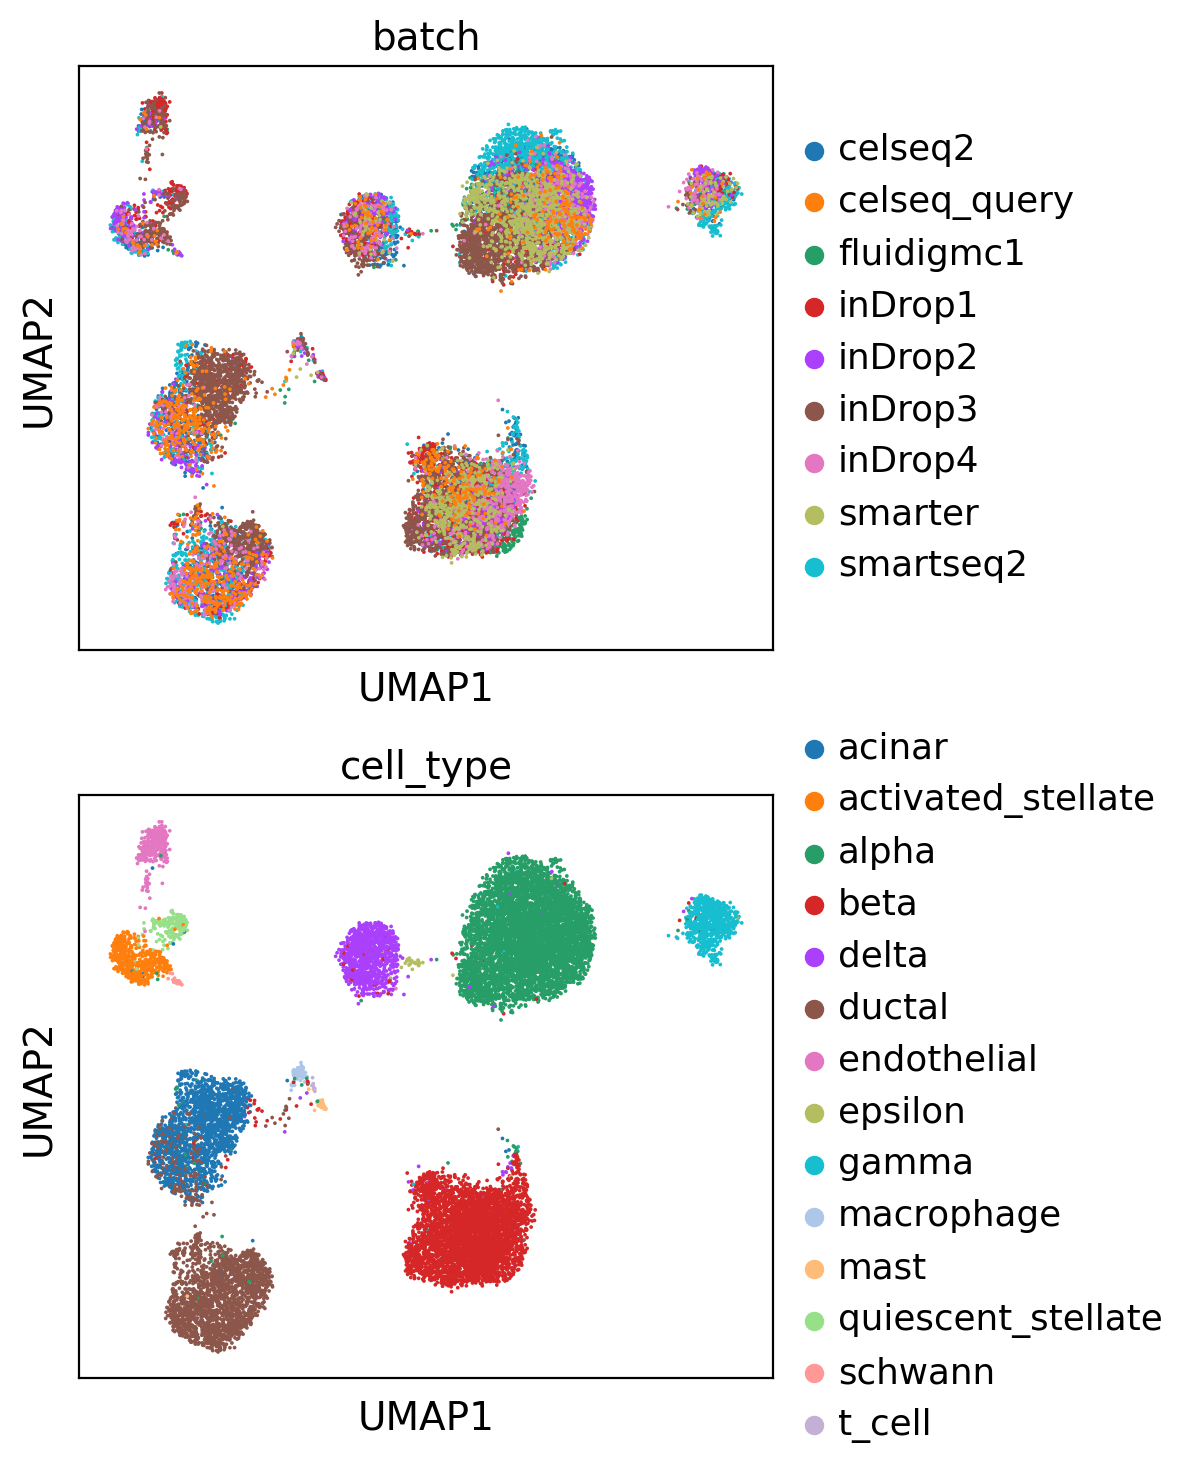

/mnt/sdc/lijiahao/miniconda3/envs/SAVE/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


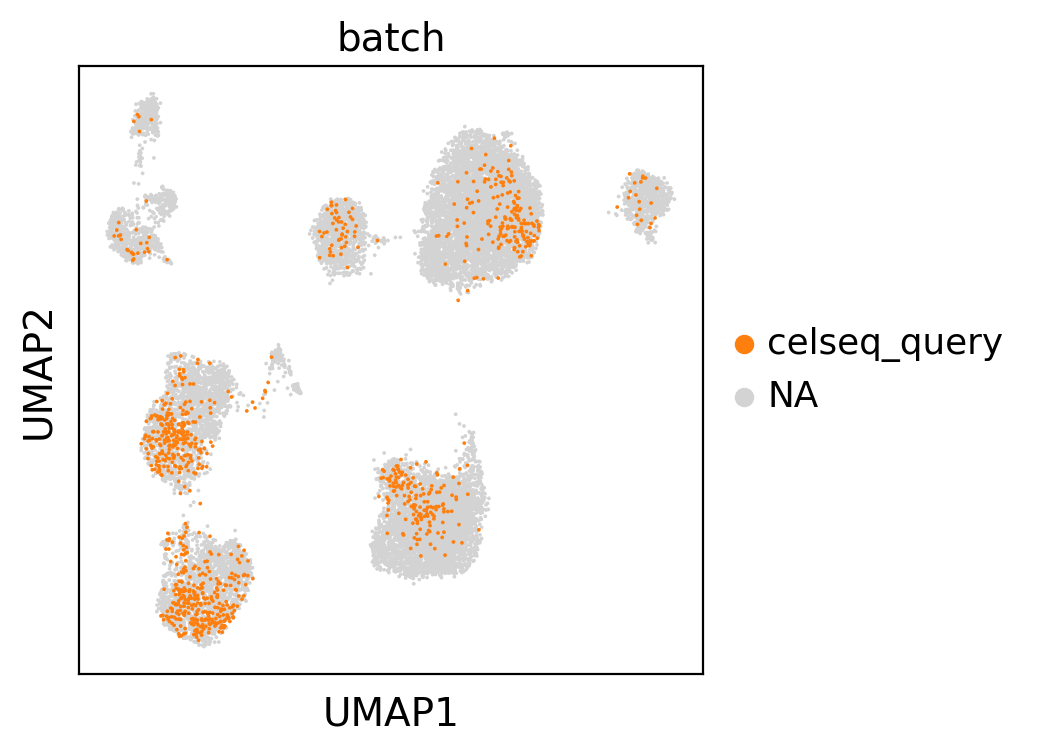

: 

In [32]:
sc.set_figure_params(dpi=100)
sc.pp.neighbors(integrated_data, use_rep="SAVE")
sc.tl.umap(integrated_data)
sc.pl.umap(integrated_data, color=["batch", "cell_type"], ncols=1)
# highlight projected batch
sc.pl.umap(integrated_data, color=["batch"], ncols=1, groups=["celseq_query"])